In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
# Suppress non-critical warnings for a cleaner output
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')

In [3]:
# --- Step 1: Data Loading and Exploration ---
print("--- Step 1: Loading and Exploring Data ---")
try:
    # Use on_bad_lines='skip' to handle potential parsing errors in the CSV file.
    df = pd.read_csv('networktraffic.csv', delimiter='|', on_bad_lines='skip')
    print("✅ Dataset loaded successfully.")
except Exception as e:
    print(f"❌ Error loading or parsing the CSV file: {e}")
    exit()

--- Step 1: Loading and Exploring Data ---
✅ Dataset loaded successfully.


In [4]:
# --- Step 2: Data Preprocessing and Feature Engineering ---
print("\n--- Step 2: Preprocessing Data and Engineering Features ---")

# Define columns for various processing steps
columns_to_drop = ['ts', 'uid', 'id.orig_h', 'id.resp_h', 'detailed-label', 'local_orig', 'local_resp', 'tunnel_parents']
categorical_cols = ['proto', 'service', 'conn_state', 'history']
numeric_cols = ['duration', 'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes']

# Drop irrelevant columns
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
print(f"Dropped columns: {columns_to_drop}")

# Replace placeholder '-' with actual NaN values
df.replace('-', np.nan, inplace=True)
print("Replaced '-' with NaN for missing value handling.")

# --- COMPREHENSIVE FIX: Impute ALL categorical columns ---
for col in categorical_cols:
    if col in df.columns and df[col].isnull().any():
        modes = df[col].mode()
        if not modes.empty:
            mode_val = modes[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled missing categorical values in '{col}' with mode ('{mode_val}').")
        else:
            # This case handles columns that are entirely empty
            df[col].fillna('unknown', inplace=True)
            print(f"Column '{col}' was empty; filled with 'unknown'.")

# Convert numeric columns, coercing errors to NaN
for col in numeric_cols:
     if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
print("Attempted to convert numeric columns.")

# Impute missing numeric values with the column median
for col in numeric_cols:
    if col in df.columns and df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f"Filled missing numeric values in '{col}' with median ({median_val}).")

# A final dropna() for any other unforeseen missing values.
df.dropna(inplace=True)
print("Final check for any remaining NaN rows completed.")

# Robustness Check
if df.empty:
    print("\n❌ CRITICAL ERROR: The DataFrame is empty after preprocessing.")
    exit()
else:
    print(f"\n✅ Preprocessing complete. Shape of the final dataset: {df.shape}")

# Encode categorical features using one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
print("Applied one-hot encoding to categorical features.")

# Encode the target 'label' column
label_encoder = LabelEncoder()
df_encoded['label'] = label_encoder.fit_transform(df_encoded['label'])
print("Encoded target variable 'label': Benign -> 0, Malicious -> 1")

# Separate features (X) and target (y)
X = df_encoded.drop('label', axis=1)
y = df_encoded['label']



--- Step 2: Preprocessing Data and Engineering Features ---
Dropped columns: ['ts', 'uid', 'id.orig_h', 'id.resp_h', 'detailed-label', 'local_orig', 'local_resp', 'tunnel_parents']
Replaced '-' with NaN for missing value handling.
Column 'service' was empty; filled with 'unknown'.
Attempted to convert numeric columns.
Filled missing numeric values in 'duration' with median (0.0059924999999999996).
Filled missing numeric values in 'orig_bytes' with median (48.0).
Filled missing numeric values in 'resp_bytes' with median (48.0).
Final check for any remaining NaN rows completed.

✅ Preprocessing complete. Shape of the final dataset: (10403, 15)
Applied one-hot encoding to categorical features.
Encoded target variable 'label': Benign -> 0, Malicious -> 1


C:\Users\rushi\AppData\Local\Temp\ipykernel_19912\1664426967.py:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('-', np.nan, inplace=True)
C:\Users\rushi\AppData\Local\Temp\ipykernel_19912\1664426967.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('unknown', inplace=

In [5]:
# --- Step 3: Unsupervised Anomaly Detection (Isolation Forest) ---
print("\n--- Step 3: Training Unsupervised Anomaly Detection Model ---")
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X)
y_pred_iso = iso_forest.predict(X)
y_pred_iso_mapped = np.where(y_pred_iso == -1, 1, 0) # Map to 0 (Normal), 1 (Anomaly)
print("✅ Isolation Forest model trained.")


--- Step 3: Training Unsupervised Anomaly Detection Model ---
✅ Isolation Forest model trained.


In [6]:
# --- Step 4: Supervised Attack Classification (Random Forest) ---
print("\n--- Step 4: Training Supervised Classification Model ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print("Split data into 70% training and 30% testing sets.")
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
print("✅ Random Forest Classifier trained.")


--- Step 4: Training Supervised Classification Model ---
Split data into 70% training and 30% testing sets.
✅ Random Forest Classifier trained.



--- Step 5: Evaluating Model Performance ---

--- Isolation Forest (Unsupervised) Evaluation ---
                               precision    recall  f1-score   support

    Benign (Predicted Normal)       0.17      0.72      0.27      2181
Malicious (Predicted Anomaly)       0.40      0.05      0.09      8222

                     accuracy                           0.19     10403
                    macro avg       0.28      0.38      0.18     10403
                 weighted avg       0.35      0.19      0.13     10403

💾 Saved Isolation Forest confusion matrix.

--- Random Forest (Supervised) Evaluation ---
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       654
   Malicious       1.00      1.00      1.00      2467

    accuracy                           1.00      3121
   macro avg       1.00      1.00      1.00      3121
weighted avg       1.00      1.00      1.00      3121

💾 Saved Random Forest confusion matrix.


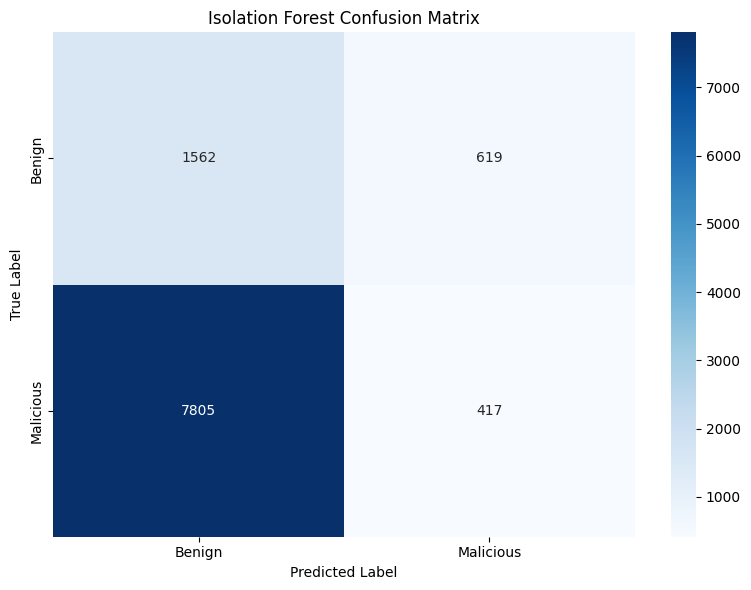

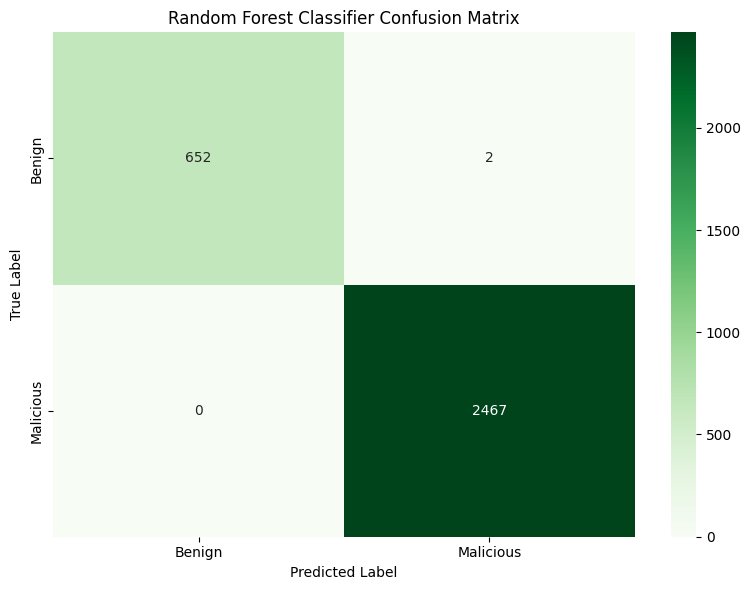

In [7]:
# --- Step 5: Model Evaluation ---
print("\n--- Step 5: Evaluating Model Performance ---")

# Evaluate Unsupervised Model
print("\n--- Isolation Forest (Unsupervised) Evaluation ---")
print(classification_report(y, y_pred_iso_mapped, target_names=['Benign (Predicted Normal)', 'Malicious (Predicted Anomaly)']))
cm_iso = confusion_matrix(y, y_pred_iso_mapped)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_iso, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title('Isolation Forest Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('isolation_forest_confusion_matrix.png')
print("💾 Saved Isolation Forest confusion matrix.")

# Evaluate Supervised Model
print("\n--- Random Forest (Supervised) Evaluation ---")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Random Forest Classifier Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.savefig('random_forest_confusion_matrix.png')
print("💾 Saved Random Forest confusion matrix.")

In [8]:
# --- Step 6: Prototype Alerting System ---
print("\n--- Step 6: Prototype Alerting System ---")
def generate_alert(prediction_label):
    predicted_class_name = label_encoder.inverse_transform([prediction_label])[0]
    if predicted_class_name == 'Malicious':
        print("\n" + "="*40)
        print("🚨 SECURITY ALERT: MALICIOUS TRAFFIC DETECTED! 🚨")
        print("="*40)
        print("Prediction: Malicious Activity")
        print("Action: Isolate the affected host and investigate immediately.")
        print("="*40 + "\n")
    else:
        print("\n" + "="*40)
        print("✅ INFO: Traffic analyzed and classified as Benign.")
        print("="*40 + "\n")

print("Simulating alerts for the first 5 records in the test set...")
for i in range(min(5, len(X_test))):
    sample_data = X_test.iloc[[i]]
    sample_prediction = rf_classifier.predict(sample_data)[0]
    generate_alert(sample_prediction)


--- Step 6: Prototype Alerting System ---
Simulating alerts for the first 5 records in the test set...

🚨 SECURITY ALERT: MALICIOUS TRAFFIC DETECTED! 🚨
Prediction: Malicious Activity
Action: Isolate the affected host and investigate immediately.


🚨 SECURITY ALERT: MALICIOUS TRAFFIC DETECTED! 🚨
Prediction: Malicious Activity
Action: Isolate the affected host and investigate immediately.


🚨 SECURITY ALERT: MALICIOUS TRAFFIC DETECTED! 🚨
Prediction: Malicious Activity
Action: Isolate the affected host and investigate immediately.


🚨 SECURITY ALERT: MALICIOUS TRAFFIC DETECTED! 🚨
Prediction: Malicious Activity
Action: Isolate the affected host and investigate immediately.


🚨 SECURITY ALERT: MALICIOUS TRAFFIC DETECTED! 🚨
Prediction: Malicious Activity
Action: Isolate the affected host and investigate immediately.

